## ROI signal extraction

In this script, fMRI signal is extracted from predefined ROIs. Different brain parcellations may be used. This version support only spherical ROIs defined as csv table with at least four columns: `x`, `y` and `z` corresponding to MNI coordinates and `radius(mm)` corresponding to each ROI size in mm. 
> In order to specify and extract signal from different brain atlas please change `path_atlas` and `atlas_name` variables.

Two versions of timseries matrices are created:
- `timeseries_raw`: from preprocessed but not denoised functional data, 
- `timeseries_denoised`: from preprocessed and denoised functional data.

Timeseries matrices are aggregated over subject and task conditions (aggregated 4D matrices are of shape `n_subjects` $\times$ `n_conditions` $\times$ `n_volumes` $\times$ `n_rois`). Aggregated matrices are saved as both numpy `.npy` files and `.mat` files. MATLAB files are used for further deconvolution perfomed with SPM functions. 

> Timeseries are stored with filenames according to BIDS-like convention: </br>`timeseres_pipeline-<pipeline_name>_atlas-<atlas_name>_[bold/neural].[npy/mat]`

---
**Last update**: 25.09.2020 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
import tempfile

from bids import BIDSLayout
from nilearn.input_data import NiftiSpheresMasker
from scipy import io

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data                    

%matplotlib inline

In [2]:
# Directory for PPI analysis
path_out = os.path.join(path_root, 'data/main_fmri_study/derivatives/ppi')
path_parcellations = os.path.join(path_out, 'parcellations')
path_timeries = os.path.join(path_out, 'timeseries')
path_bids = os.path.join(path_root, 'data/main_fmri_study')
path_fmridenoise = os.path.join(path_bids, 'derivatives/fmridenoise')

# Atlases
path_custom_roi = os.path.join(
    path_parcellations, 
    'custom_roi/custom_roi_table.csv')
path_meta_roi = os.path.join(
    path_parcellations, 
    'meta2_roi/meta2_roi_table.csv')                                            # !!!
path_300_roi = os.path.join(
    path_parcellations, 
    '300_ROI_Set/ROIs_300inVol_MNI_allInfo.txt')

# Load behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh, verbose=False)
n_subjects, n_conditions, n_trials, _ = beh.shape
n_volumes = 730
n_confounds = 32

# Name of the pipeline used for fMRI data denoising
denoising_pipeline_name = '24HMPCSFWM'

### Query neuroimaging dataset

Grab necessary fMRI files:
- `fmri_files_raw`: dictionary with keys corresponding to task condition lables and values being list of paths to preprocessed imaging files
- `fmri_files_denoised`: dictionary with keys corresponding to task condition lables and values being list of paths to preprocessed and denoised imaging files



In [3]:
layout = BIDSLayout(
    root=path_bids,
    derivatives=True,
    validate=True,
    index_metadata=False
)

fmri_filter = {
    'extension': ['.nii', '.nii.gz'],
    'space': 'MNI152NLin2009cAsym',
    'suffix': 'bold',
    'desc': 'preproc',
    'return_type': 'filename'
}

fmri_files_raw = {}
fmri_files_denoised = {}

for task_dict in [{'task': 'prlrew'}, {'task': 'prlpun'}]:
    fmri_filter.update(task_dict)
    fmri_files_raw[task_dict['task']] = layout.get(**fmri_filter)
    fmri_files_denoised[task_dict['task']] = sorted([
        os.path.join(path_fmridenoise, fname) 
        for fname in os.listdir(path_fmridenoise) 
        if task_dict['task'] in fname
    ])

## Choose brain parcellation
---

In [4]:
path_atlas = path_meta_roi
atlas_name = 'meta2ROI'

---

### Load brain parcellation

Here brain parcellation is loaded. Parcellaton should be stored and formatted as csv file with (at least these) columns:

| Column Name | Description |
|:--:|----|
| `x` | x MNI coordinate for ROI center | 
| `y` | y MNI coordinate for ROI center | 
| `z` | z MNI coordinate for ROI center | 
| `radius(mm)` | sphere radius in mm |

Since `NiftiSpheresMasker` class accepts only single radius value, different maskers are created for all unique radii values (if needed). 

In [5]:
df_atlas = pd.read_csv(path_atlas)
seeds = [tuple(coords[1]) for coords in df_atlas[['x', 'y', 'z']].iterrows()]
n_rois = len(seeds)

# Dict for storing maskers for different radii values
rois = {}

for radius in df_atlas['radius(mm)'].unique():
    # Select ROIs with given radius
    roi_indices = np.flatnonzero(df_atlas['radius(mm)'] == radius)
    
    # Create masker for single radius value
    masker = NiftiSpheresMasker(
        [seeds[idx] for idx in roi_indices], 
        radius=radius,                
        mask_img=None,            
        allow_overlap=True, 
        standardize='zscore', 
        detrend=True, 
        high_pass=1/128,
        t_r=2
    )
    
    rois[radius] = {'masker': masker, 'indices': roi_indices}

### Extract signal

Resulting timecourses are stored in 4-dimensional array with dimensions corresponding to subjects, tasks, volumes and roi's. 

Matrix shape is `n_subjects` $\times$ `n_conditions` $\times$ `n_volumes` $\times$ `n_rois`. 

In [6]:
timeseries_denoised_aggregated = np.zeros(
    (n_subjects, n_conditions, n_volumes, n_rois))
timeseries_raw_aggregated = np.zeros(
    (n_subjects, n_conditions, n_volumes, n_rois))

for con_idx, con_name in enumerate(meta['dim2']):    
    for sub_idx, sub_name in enumerate(meta['dim1']):
        print(f'Processing sub-{sub_name}, condition: {con_name}')
        
        fmri_file_raw = fmri_files_raw[f'prl{con_name}'][sub_idx]
        fmri_file_denoised = fmri_files_denoised[f'prl{con_name}'][sub_idx]

        timeseries_denoised = np.zeros((n_volumes, n_rois))
        timeseries_raw = np.zeros((n_volumes, n_rois))
        
        for radius in rois:
            # Get indices to insert computed timeseries into right positions
            roi_indices = rois[radius]['indices']

            # Extract timeseries
            timeseries_denoised[:, roi_indices] = rois[radius]['masker'].fit_transform(
                fmri_file_denoised, confounds=None
            )
            timeseries_raw[:, roi_indices] = rois[radius]['masker'].fit_transform(
                fmri_file_raw, confounds=None
            )
            
        # Store results in corresponding arrays
        timeseries_denoised_aggregated[sub_idx][con_idx] = timeseries_denoised
        timeseries_raw_aggregated[sub_idx][con_idx] = timeseries_raw

    
fname_denoised = f'timeseries_pipeline-{denoising_pipeline_name}_atlas-{atlas_name}_bold'
fname_raw = f'timeseries_pipeline-null_atlas-{atlas_name}_bold'
    
# Save in numpy format
np.save(os.path.join(
    path_timeries, fname_denoised), 
    timeseries_denoised_aggregated)
np.save(os.path.join(
    path_timeries, fname_raw), 
    timeseries_raw_aggregated)

# Save for further SPM use
io.savemat(os.path.join(path_timeries, fname_denoised + '.mat'), 
           {'timeseries_denoised_aggregated': timeseries_denoised_aggregated})
io.savemat(os.path.join(path_timeries, fname_raw + '.mat'), 
           {'timeseries_raw_aggregated': timeseries_raw_aggregated})

Processing sub-m02, condition: rew
Processing sub-m03, condition: rew
Processing sub-m04, condition: rew
Processing sub-m05, condition: rew
Processing sub-m06, condition: rew
Processing sub-m07, condition: rew
Processing sub-m08, condition: rew
Processing sub-m09, condition: rew
Processing sub-m10, condition: rew
Processing sub-m11, condition: rew
Processing sub-m12, condition: rew
Processing sub-m13, condition: rew
Processing sub-m14, condition: rew
Processing sub-m15, condition: rew
Processing sub-m16, condition: rew
Processing sub-m17, condition: rew
Processing sub-m18, condition: rew
Processing sub-m19, condition: rew
Processing sub-m20, condition: rew
Processing sub-m21, condition: rew
Processing sub-m22, condition: rew
Processing sub-m23, condition: rew
Processing sub-m24, condition: rew
Processing sub-m25, condition: rew
Processing sub-m26, condition: rew
Processing sub-m27, condition: rew
Processing sub-m28, condition: rew
Processing sub-m29, condition: rew
Processing sub-m30, 

### Plot extracted signal from single subject

Show carpet plot of cleaned BOLD signal from all predefined ROIs.

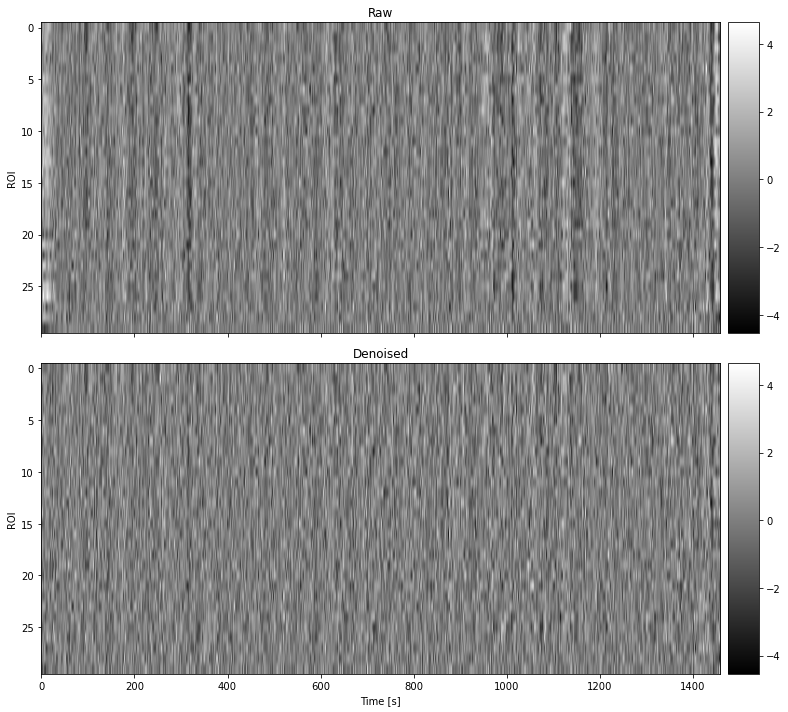

In [7]:
fig, axs = plt.subplots(nrows=2, figsize=(12, 10), facecolor='w', sharex=True)

carpet_raw = axs[0].imshow(timeseries_raw_aggregated[0][0].T,
                           aspect='auto', cmap='gray')
carpet_denoised = axs[1].imshow(timeseries_denoised_aggregated[0][0].T, 
                                aspect='auto', cmap='gray')
carpet_denoised.set_clim(carpet_raw.get_clim())

for ax in axs:
    ax.set_ylabel('ROI')
    ax.set_xticklabels([f'{t:.0f}' for t in 2 * ax.get_xticks()])


axs[0].set_title('Raw')
axs[1].set_title('Denoised')
axs[1].set_xlabel('Time [s]')

fig.colorbar(carpet_raw, ax=axs[0], pad=0.01, shrink=1, aspect=10)
fig.colorbar(carpet_denoised, ax=axs[1], pad=0.01, shrink=1, aspect=10)

plt.tight_layout()
plt.show()